### Imports and reading in the dataset

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import seaborn as sns

%matplotlib inline


In [246]:
current_dir = os.getcwd()
filename = '13 million Duolingo student learning traces.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/', filename))

df = pd.read_csv(filepath)

# Take a sample of dataframe 
df = df.sample(500000)

In [147]:
""" 
p_recall - session_correct/session_seen
timestamp - UNIX timestamp of the current lesson
delta - time (in seconds) since the last lesson that included this word
user_id - student user ID
learning_language - language being learned
ui_language - user interface language (presumably native to the student)
lexeme_id - system ID for the lexeme tag (i.e., word)
lexeme_string - lexeme tag for word
history_seen - total times user has seen the word prior to this lesson
history_correct - total times user has been correct for the word prior to this lesson
session_seen - times the user saw the word during this lesson
session_correct - times the user got the word correct during this lesson
"""


' \np_recall - session_correct/session_seen\ntimestamp - UNIX timestamp of the current lesson\ndelta - time (in seconds) since the last lesson that included this word\nuser_id - student user ID\nlearning_language - language being learned\nui_language - user interface language (presumably native to the student)\nlexeme_id - system ID for the lexeme tag (i.e., word)\nlexeme_string - lexeme tag for word\nhistory_seen - total times user has seen the word prior to this lesson\nhistory_correct - total times user has been correct for the word prior to this lesson\nsession_seen - times the user saw the word during this lesson\nsession_correct - times the user got the word correct during this lesson\n'

### Data Preparation

In [247]:
# Set the index
df.reset_index(inplace=True, drop=True)
# df.drop('timestamp', axis=1, inplace=True)

In [248]:
# Check the types
df.dtypes

p_recall             float64
timestamp              int64
delta                  int64
user_id               object
learning_language     object
ui_language           object
lexeme_id             object
lexeme_string         object
history_seen           int64
history_correct        int64
session_seen           int64
session_correct        int64
dtype: object

In [249]:
# Check for na
df.isna().any()

p_recall             False
timestamp            False
delta                False
user_id              False
learning_language    False
ui_language          False
lexeme_id            False
lexeme_string        False
history_seen         False
history_correct      False
session_seen         False
session_correct      False
dtype: bool

In [250]:
# Check for duplicates
df.duplicated().any()
df.drop_duplicates(inplace=True)

In [251]:
# Create new column ui language - learning language 
df['lang'] = df['ui_language'] + '-' + df['learning_language']

In [252]:
# Retrieve numeric columns 
df_numeric = df.select_dtypes(np.number)
features = df_numeric.columns.tolist()

# Retrieve object columns  
df_obj = df.select_dtypes(include='object')

In [253]:
# Describe numerical columns 
num_desc = df.describe().map(lambda x: f"{x:0.3f}")
num_desc

,p_recall,timestamp,delta,history_seen,history_correct,session_seen,session_correct
count,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000,500000.000
mean,0.896,1362589471.741,727349.645,21.933,19.290,1.818,1.645
std,0.271,293398.804,2234074.877,123.777,105.388,1.357,1.316
min,0.000,1362082389.000,1.000,1.000,1.000,1.000,0.000
25%,1.000,1362342776.000,531.000,3.000,3.000,1.000,1.000
50%,1.000,1362591375.000,76826.000,6.000,6.000,1.000,1.000
75%,1.000,1362846398.250,440698.750,15.000,13.000,2.000,2.000
max,1.000,1363104894.000,39758305.000,13345.000,12726.000,20.000,20.000


In [254]:
print(f"""
P_RECALL (proportion of correct answers to total answers in one session): the mean is {num_desc['p_recall'].loc['mean']}, the median is {num_desc['p_recall'].loc['50%']}.
More than 75% users can answer all questions correctly in one session.

DELTA: the mean is {round(float(num_desc['delta'].loc['mean'])/(60*60*60),2)} days between sessions, the median is {round(float(num_desc['delta'].loc['50%'])/(60*60*60),2)} days. 
Max value is {round(float(num_desc['delta'].loc['max'])/(60*60*60),2)} days, 
75% users have less than {round(float(num_desc['delta'].loc['75%'])/(60*60*60),2)} between sessions. Likely outliers. 

HISTORY SEEN: median is {num_desc['history_seen'].loc['50%']} times seen prior to this session,the max is very high {num_desc['history_seen'].loc['max']}

HISTORY CORRECT: median is {num_desc['history_correct'].loc['50%']} times correct, standard deviation {num_desc['history_correct'].loc['std']}. 

SESSION SEEN: usually around {num_desc['session_seen'].loc['50%']} time seen during session, mean {num_desc['session_seen'].loc['mean']}. 

SESSION CORRECT: mean {num_desc['session_correct'].loc['mean']}, median {num_desc['session_correct'].loc['50%']}""")



P_RECALL (proportion of correct answers to total answers in one session): the mean is 0.896, the median is 1.000.
More than 75% users can answer all questions correctly in one session.

DELTA: the mean is 3.37 days between sessions, the median is 0.36 days. 
Max value is 184.07 days, 
75% users have less than 2.04 between sessions. Likely outliers. 

HISTORY SEEN: median is 6.000 times seen prior to this session,the max is very high 13345.000

HISTORY CORRECT: median is 6.000 times correct, standard deviation 105.388. 

SESSION SEEN: usually around 1.000 time seen during session, mean 1.818. 

SESSION CORRECT: mean 1.645, median 1.000


In [255]:
# Describe categorical columns
obj_desc = df.describe(include=['O'])
obj_desc

,user_id,learning_language,ui_language,lexeme_id,lexeme_string,lang
count,500000,500000,500000,500000,500000,500000
unique,75485,6,4,11179,10965,8
top,u:bcH_,en,en,827a8ecb89f9b59ac5c29b620a5d3ed6,a/a<det><ind><sg>,es-en
freq,728,195154,304846,4652,4652,141680


In [256]:
print(f"""there are {obj_desc['user_id'].loc['unique']} unique users, learning 6 languages. The most popular language is {obj_desc['learning_language'].loc['top']}
with {100*(int(obj_desc['learning_language'].loc['freq'])/int(obj_desc['learning_language'].loc['count']))}% of total observations.""")

there are 75485 unique users, learning 6 languages. The most popular language is en
with 39.0308% of total observations.


### Delete outliers

In [257]:
z = np.abs(stats.zscore(df_numeric))       
print(z.max())

p_recall             3.310600
timestamp            1.756731
delta               17.470764
history_seen       107.637451
history_correct    120.570515
session_seen        13.397597
session_correct     13.951834
dtype: float64


In [258]:
threshold_z = 3
z = np.abs(stats.zscore(df_numeric))   
df = df[(z < threshold_z).all(axis=1)]


print("Original DataFrame Shape:", df_numeric.shape[0])
print("DataFrame Shape after Removing Outliers:", df.shape[0])
print('Rows removed', df_numeric.shape[0]- df.shape[0])


df_numeric = df.select_dtypes(np.number)
print('Z after removal', np.abs(stats.zscore(df_numeric)).max())  


Original DataFrame Shape: 500000
DataFrame Shape after Removing Outliers: 442204
Rows removed 57796
Z after removal p_recall            6.556249
timestamp           1.759891
delta               6.916547
history_seen       12.388477
history_correct    11.698379
session_seen        3.108828
session_correct     3.443403
dtype: float64


In [259]:
# Describe after removal 
num_desc = df.describe().map(lambda x: f"{x:0.3f}")

In [260]:
print(f"""
P_RECALL (proportion of correct answers to total answers in one session): the mean is {num_desc['p_recall'].loc['mean']}, the median is {num_desc['p_recall'].loc['50%']}.
More than 75% users can answer all questions correctly in one session.

DELTA: the mean is {round(float(num_desc['delta'].loc['mean'])/(60*60*60),2)} days between sessions, the median is {round(float(num_desc['delta'].loc['50%'])/(60*60*60),2)} days. 
Max value is {round(float(num_desc['delta'].loc['max'])/(60*60*60),2)} days, 
75% users have less than {round(float(num_desc['delta'].loc['75%'])/(60*60*60),2)} between sessions.

HISTORY SEEN: median is {num_desc['history_seen'].loc['50%']} times seen prior to this session,the max is very high {num_desc['history_seen'].loc['max']}

HISTORY CORRECT: median is {num_desc['history_correct'].loc['50%']} times correct, standard deviation {num_desc['history_correct'].loc['std']}. 

SESSION SEEN: usually around {num_desc['session_seen'].loc['50%']} time seen during session, mean {num_desc['session_seen'].loc['mean']}. 

SESSION CORRECT: mean {num_desc['session_correct'].loc['mean']}, median {num_desc['session_correct'].loc['50%']}""")


P_RECALL (proportion of correct answers to total answers in one session): the mean is 0.966, the median is 1.000.
More than 75% users can answer all questions correctly in one session.

DELTA: the mean is 2.14 days between sessions, the median is 0.32 days. 
Max value is 34.39 days, 
75% users have less than 1.88 between sessions.

HISTORY SEEN: median is 6.000 times seen prior to this session,the max is very high 392.000

HISTORY CORRECT: median is 6.000 times correct, standard deviation 27.424. 

SESSION SEEN: usually around 1.000 time seen during session, mean 1.737. 

SESSION CORRECT: mean 1.642, median 1.000


### Frequency of learning languages 

In [261]:
langs_sizes = df.groupby(['lang']).size().to_frame('count')
langs_sizes['% obs'] = (langs_sizes['count']/langs_sizes['count'].sum())*100
print(langs_sizes)

target_langs = df.groupby(['learning_language']).size().to_frame('count')
target_langs['% obs'] = (target_langs['count']/target_langs['count'].sum())*100
print(target_langs)

        count      % obs
lang                    
en-de   49404  11.172219
en-es  117793  26.637706
en-fr   63934  14.458033
en-it   28181   6.372851
en-pt   10905   2.466056
es-en  123972  28.035025
it-en   15313   3.462881
pt-en   32702   7.395229
                    count      % obs
learning_language                   
de                  49404  11.172219
en                 171987  38.893135
es                 117793  26.637706
fr                  63934  14.458033
it                  28181   6.372851
pt                  10905   2.466056


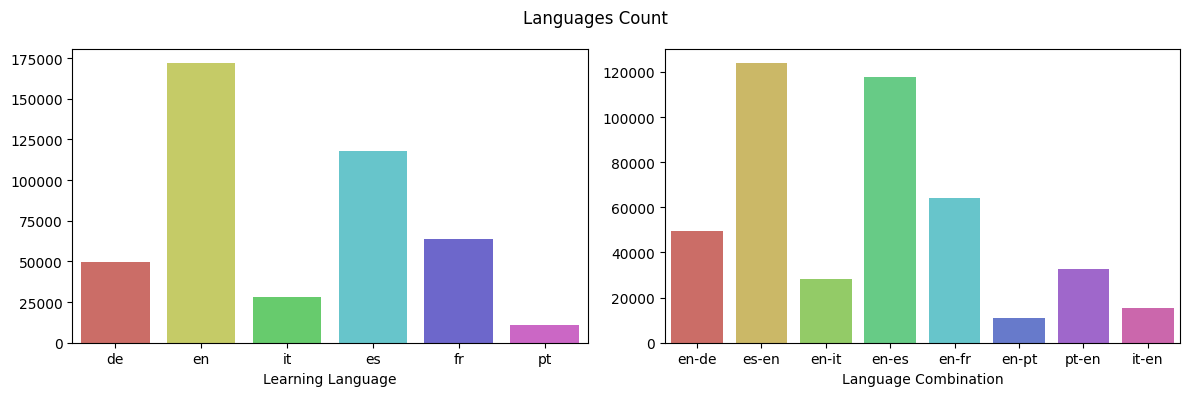

In [262]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
a = sns.countplot(x='learning_language', data=df, ax=axes[0], palette='hls')
b = sns.countplot(x='lang', data=df, ax=axes[1], palette='hls')
a.set(ylabel=None, xlabel='Learning Language')
b.set(ylabel=None, xlabel='Language Combination')
plt.suptitle('Languages Count')

plt.tight_layout()
plt.show()

### Repetitions during sessions

In [263]:
sessions_size = df.groupby(["session_seen", "session_correct"]).size().reset_index(name='counts')
sessions_size

,session_seen,session_correct,counts
0,1,1,254987
1,2,1,15956
2,2,2,82547
3,3,1,1069
4,3,2,10368
5,3,3,39825
6,4,1,60
7,4,2,939
8,4,3,6113
9,4,4,17968


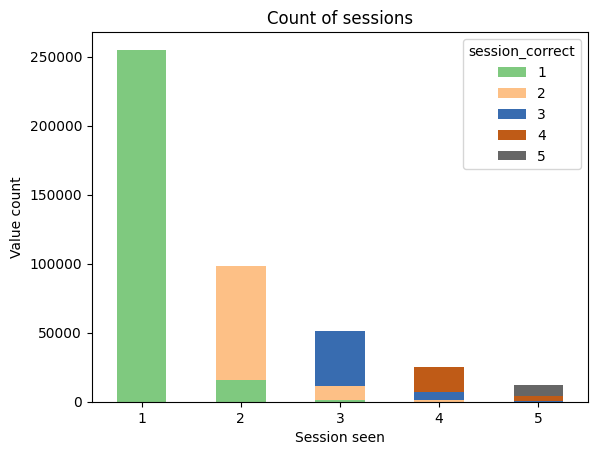

In [264]:
pivot_sess = sessions_size.pivot(index='session_seen', columns='session_correct', values='counts')
pivot_sess.plot(kind='bar', stacked=True, colormap='Accent')

plt.ylabel('Value count')
plt.xlabel('Session seen')
plt.title('Count of sessions')
plt.xticks(rotation='horizontal')

plt.show()

### Timestamp analysis

In [374]:
from datetime import datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop(columns=['timestamp'], inplace=True)
df['weekday'] = df['datetime'].dt.day_name()
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
print(f'Range of dates: from {df['datetime'].min()} to {df['datetime'].max()}')
print(f'The first day of observation is {(df['datetime'].min().to_pydatetime().strftime('%A'))}, the last is {(df['datetime'].max().to_pydatetime().strftime('%A'))}')


Range of dates: from 2013-02-28 20:13:09 to 2013-03-12 16:14:54
The first day of observation is Thursday, the last is Tuesday


In [382]:
# Take only one week
start_date = pd.to_datetime('2013-03-01').date()
end_date = pd.to_datetime('2013-03-07').date()

df_dates = df[df['date'].between(start_date, end_date)]
print(f'Range of dates: from {df_dates['datetime'].min()} to {df_dates['datetime'].max()}')
print(f'The first day of observation is {(df_dates['datetime'].min().to_pydatetime().strftime('%A'))}, the last is {(df_dates['datetime'].max().to_pydatetime().strftime('%A'))}')


Range of dates: from 2013-03-01 00:00:00 to 2013-03-07 23:59:50
The first day of observation is Friday, the last is Thursday


Text(0.5, 1.0, 'Number of users during the week')

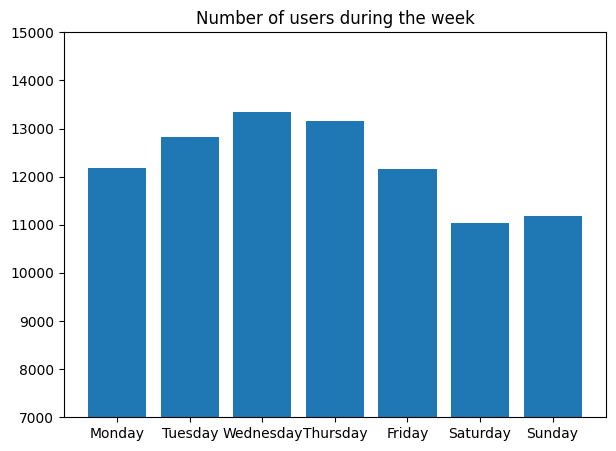

In [400]:
df_hours = df_dates[['weekday', 'user_id']].groupby('weekday').nunique().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()
fig, ax = plt.subplots(figsize = (7, 5))
ax.bar(df_hours['weekday'], df_hours['user_id'])
ax.set(ylim=[7000, 15000])
plt.title('Number of users during the week')

### Lexeme string analysis 

### Visualize distributions of numeric variables - boxplots


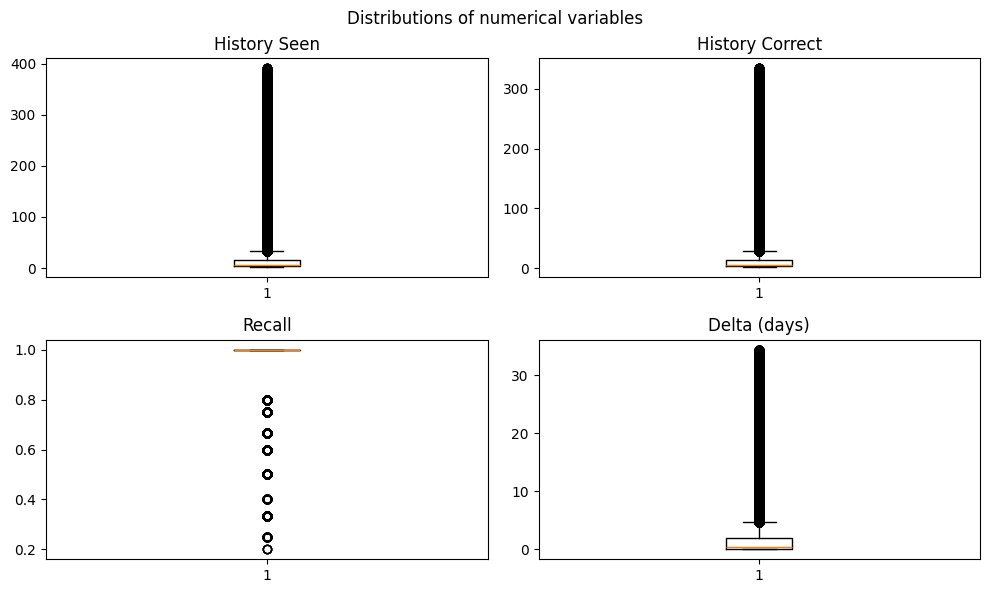

In [292]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

axs[0,0].boxplot(df['history_seen'])
axs[0,0].set_title('History Seen')

axs[1,0].boxplot(df['p_recall'])
axs[1,0].set_title('Recall')

axs[0,1].boxplot(df['history_correct'])
axs[0,1].set_title('History Correct')

axs[1,1].boxplot(df['delta']/(60*60*60))
axs[1,1].set_title('Delta (days)')

plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Distributions of numerical variables')
fig.tight_layout()
fig.subplots_adjust(top=0.9)  

plt.show()

### Visualize distributions of numeric variables - histograms

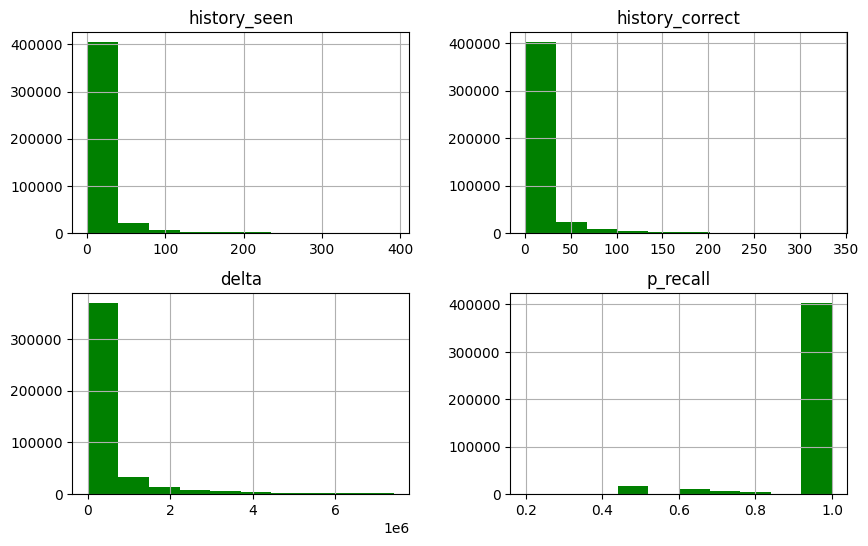

In [315]:
features = ['history_seen', 'history_correct', 'delta', 'p_recall']
fig, axes = df[features].hist(figsize=(10,6), color='green')
plt.ticklabel_format(style = 'plain')
plt.show()

### Boxplots one by one by language combination

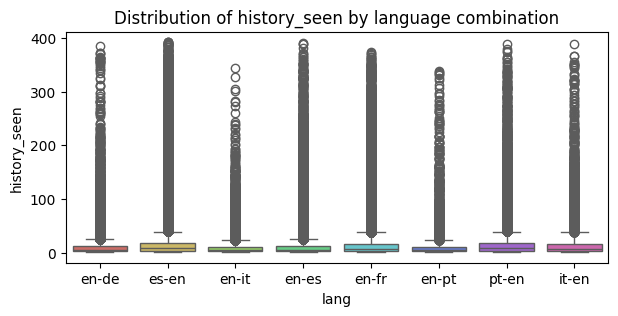

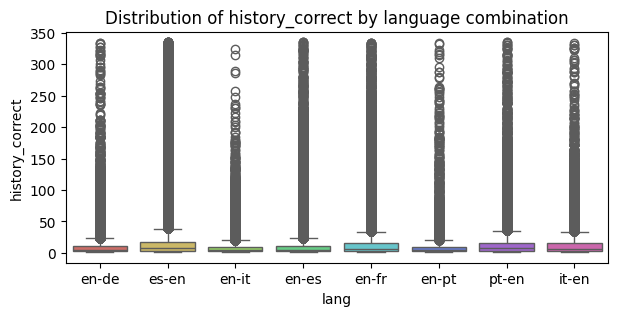

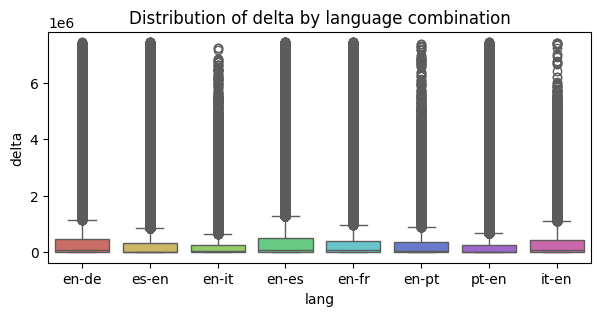

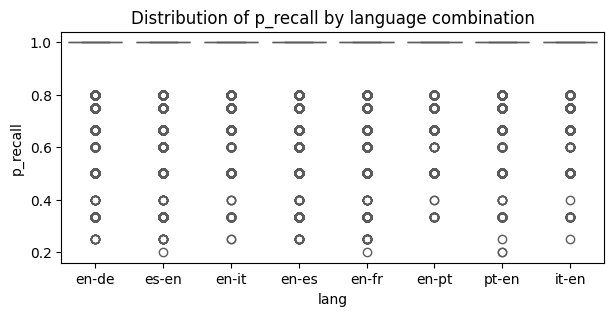

In [336]:
for y in features:
    plt.figure(figsize=(7, 3))
    sns.boxplot(x="lang", y=y, data=df, palette = 'hls')
    plt.title(f'Distribution of {y} by language combination')
    plt.show()


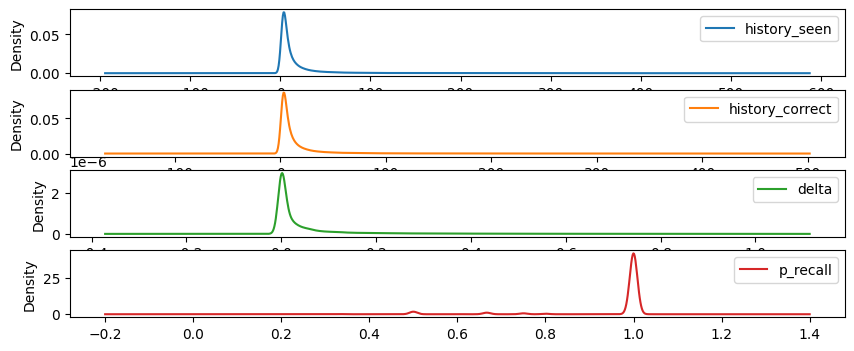

In [295]:
df[features].plot(kind='density',subplots=True,
                  sharex=False,figsize=(10,4))
plt.tight_layout
plt.show()


### Relationship between variables - scatterplot

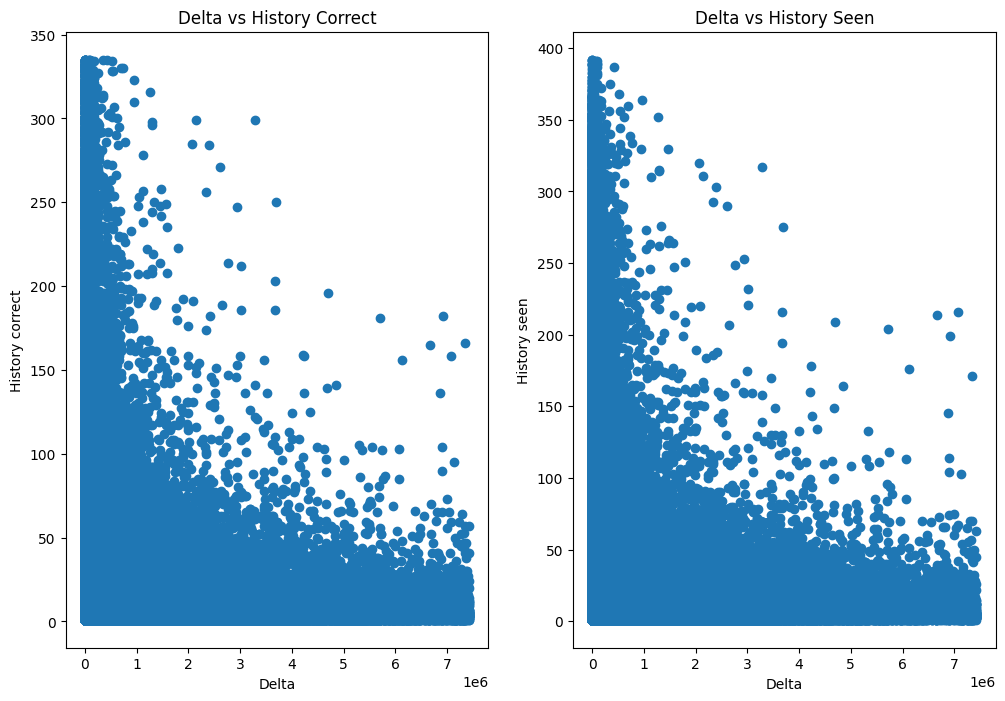

In [302]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].scatter(df['delta'], df['history_correct'])
axs[0].set_xlabel('Delta')
axs[0].set_ylabel('History correct')
axs[0].set_title('Delta vs History Correct')

axs[1].scatter(df['delta'], df['history_seen'])
axs[1].set_xlabel('Delta')
axs[1].set_ylabel('History seen')
axs[1].set_title('Delta vs History Seen')

plt.show()

### Relationship between variables - heatmap

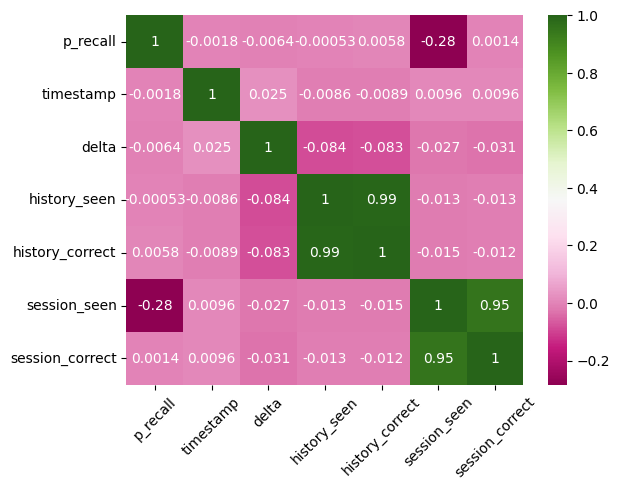

In [303]:
ax = sns.heatmap(df_numeric.corr(), cmap="PiYG", annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

### Dataset preparation for machine learning

In [78]:

df2 = df.copy()
learning_languages = df2['learning_language'].unique()
ui_languages = df2['ui_language'].unique()
lang_combinations = df2['lang'].unique()

# for l_lang in learning_languages:
#     df2['l_lang_'+l_lang] = df2['learning_language'].apply(lambda s: int(l_lang in s))

# for ui_lang in ui_languages:
#     df2['ui_lang_'+ui_lang] = df2['ui_language'].apply(lambda s: int(ui_lang in s))

for lang in lang_combinations:
    df2[lang] = df2['lang'].apply(lambda s: int(lang in s))

df2.drop(columns=['learning_language', 'ui_language', 'lang'])
df2.head()

,p_recall,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,lang,es-en,fr-en,en-pt,de-en,en-es,en-it,it-en,pt-en
0,1.0,894695,u:irDJ,es,en,2d8e4defa44f2512883a85f2c0ea46b4,ropa/ropa<n><f><sg>,1,1,2,2,es-en,1,0,0,0,0,0,0,0
1,1.0,1134,u:eTel,fr,en,be70637289b60b17de3b22270462e5bf,un/un<det><ind><m><sg>,42,39,2,2,fr-en,0,1,0,0,0,0,0,0
3,1.0,1081,u:h8c3,en,pt,17632879145d3e2737d11a3a5053dd50,his/his<det><pos><sp>,2,2,1,1,en-pt,0,0,1,0,0,0,0,0
4,1.0,58249,u:P03,de,en,2ac4ffe95f75b15d1d99aeebbb8321c7,ist/sein<vbser><pri><p3><sg>,4,4,2,2,de-en,0,0,0,1,0,0,0,0
5,1.0,17363,u:iUaS,es,en,3c317e367d8d299c237e618dd5dde5da,vino/vino<n><m><sg>,5,5,3,3,es-en,1,0,0,0,0,0,0,0
